## Setup

In [2]:
import os
from google.cloud import storage
from google.cloud import vision


def authenticate_implicit_with_adc(project_id="argon-producer-437209-a7"):
    """
    When interacting with Google Cloud Client libraries, the library can auto-detect the
    credentials to use.

    // TODO(Developer):
    //  1. Before running this sample,
    //  set up ADC as described in https://cloud.google.com/docs/authentication/external/set-up-adc
    //  2. Replace the project variable.
    //  3. Make sure that the user account or service account that you are using
    //  has the required permissions. For this sample, you must have "storage.buckets.list".
    Args:
        project_id: The project id of your Google Cloud project.

    Basically, run:
        1. gcloud init
        2. gcloud auth application-default login
    At each step, login via browser. This will save credentials to $HOME/.config/gcloud/application_default_credentials.json
    """

    # This snippet demonstrates how to list buckets.
    # *NOTE*: Replace the client created below with the client required for your application.
    # Note that the credentials are not specified when constructing the client.
    # Hence, the client library will look for credentials using ADC.
    storage_client = storage.Client(project=project_id)
    buckets = storage_client.list_buckets()
    print("Buckets:")
    for bucket in buckets:
        print(bucket.name)
    print("Listed all storage buckets.")

In [2]:
authenticate_implicit_with_adc()

Buckets:
quo-trial
Listed all storage buckets.


In [5]:
storage_client = storage.Client(project="argon-producer-437209-a7")

In [6]:
bucket = storage_client.get_bucket('quo-trial')

In [7]:
client = storage.Client(project='argon-producer-437209-a7')
blobs = client.list_blobs('quo-trial', prefix='indices')
files = [file.name for file in blobs]
files.sort(reverse=True)

In [8]:
files

['indices/index_import_2024-11-08.csv', 'indices/index_import_2024-11-07.csv']

In [27]:
blobs = storage_client.list_blobs('quo-trial')

files = []
# Note: The call returns a response only when the iterator is consumed.
for blob in blobs:
    files.append(blob.name)


In [36]:
with open('reference_images2.csv', 'w+') as f :
    for x in files:
        if x.endswith('.jpg') or x.endswith('png'):
            parts = x.split('/')
            f.writelines(f"gs://quo-trial/{x},,master_set,{parts[1]},apparel-v2,{parts[1]},\"style=women,category=tops\",\n")

In [6]:
project_id = "argon-producer-437209-a7"
location = "us-east1"
product_set_id = "master_set"  # "lovebonito-top"
product_category = "apparel-v2"

## Index

In [21]:
def import_product_sets(project_id, location, gcs_uri):
    """Import images of different products in the product set.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        gcs_uri: Google Cloud Storage URI.
            Target files must be in Product Search CSV format.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Set the input configuration along with Google Cloud Storage URI
    gcs_source = vision.ImportProductSetsGcsSource(csv_file_uri=gcs_uri)
    input_config = vision.ImportProductSetsInputConfig(gcs_source=gcs_source)

    # Import the product sets from the input URI.
    response = client.import_product_sets(
        parent=location_path, input_config=input_config
    )

    print(f"Processing operation name: {response.operation.name}")
    # synchronous check of operation status
    result = response.result()
    print("Processing done.")

    for i, status in enumerate(result.statuses):
        print("Status of processing line {} of the csv: {}".format(i, status))
        # Check the status of reference image
        # `0` is the code for OK in google.rpc.Code.
        if status.code == 0:
            reference_image = result.reference_images[i]
            print(reference_image)
        else:
            print(f"Status code not OK: {status.message}")

In [37]:
project_id = "argon-producer-437209-a7"
location = "us-east1"
gcs_uri = "gs://quo-trial/reference_images.csv"
import_product_sets(project_id, location, gcs_uri)

Processing operation name: projects/argon-producer-437209-a7/locations/us-east1/operations/08942a8117087a76
Processing done.
Status of processing line 0 of the csv: 
name: "projects/argon-producer-437209-a7/locations/us-east1/products/aara-ruched-tie-back-top/referenceImages/618165782782179958-0"
uri: "gs://quo-trial/lovebonito_top/aara-ruched-tie-back-top/hy5963-031_umvulxp1vy9wjl6k.jpg"

Status of processing line 1 of the csv: 
name: "projects/argon-producer-437209-a7/locations/us-east1/products/abbye-printed-high-neck-top/referenceImages/618165782782179958-1"
uri: "gs://quo-trial/lovebonito_top/abbye-printed-high-neck-top/fm0207-005-1_4.jpg"

Status of processing line 2 of the csv: 
name: "projects/argon-producer-437209-a7/locations/us-east1/products/abbye-printed-high-neck-top/referenceImages/618165782782179958-2"
uri: "gs://quo-trial/lovebonito_top/abbye-printed-high-neck-top/fm0207-005_3.jpg"

Status of processing line 3 of the csv: 
name: "projects/argon-producer-437209-a7/locat

IndexError: list index (3337) out of range

In [16]:
project_id = "argon-producer-437209-a7"
location = "us-east1"

client = vision.ProductSearchClient()
product_sets = client.list_product_sets(parent=f"projects/{project_id}/locations/{location}")
for product_set in product_sets:
    print(f"Product set name: {product_set.name}")
    print("Product set id: {}".format(product_set.name.split("/")[-1]))
    print(f"Product set display name: {product_set.display_name}")
    print("Product set index time: ")
    print(product_set.index_time)

Product set name: projects/argon-producer-437209-a7/locations/us-east1/productSets/set_A
Product set id: set_A
Product set display name:  
Product set index time: 
1970-01-01 00:00:00+00:00


In [13]:
def delete_product_set(project_id, location, product_set_id):
    """Delete a product set.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location, product_set=product_set_id
    )

    # Delete the product set.
    client.delete_product_set(name=product_set_path)
    print("Product set deleted.")

In [17]:
product_sets = client.list_product_sets(parent=f"projects/{project_id}/locations/{location}")
for product_set in product_sets:
    print(product_set.name.split('/')[-1])
    delete_product_set(project_id, location, product_set.name.split('/')[-1])

set_A
Product set deleted.


## Search

In [41]:

def get_similar_products_file(
    project_id,
    location,
    product_set_id,
    product_category,
    file_path,
    filter,
    max_results,
):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
                Example for filter: (color = red OR color = blue) AND style = kids
                It will search on all products with the following labels:
                color:red AND style:kids
                color:blue AND style:kids
        max_results: The maximum number of results (matches) to return. If omitted, all results are returned.
    """
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, "rb") as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.Image(content=content)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location, product_set=product_set_id
    )
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter,
    )
    image_context = vision.ImageContext(product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context, max_results=max_results
    )

    index_time = response.product_search_results.index_time
    print("Product set index time: ")
    print(index_time)

    results = response.product_search_results.results

    print("Search results:")
    for result in results:
        product = result.product

        print(f"Score(Confidence): {result.score}")
        print(f"Image name: {result.image}")

        print(f"Product name: {product.name}")
        print("Product display name: {}".format(product.display_name))
        print(f"Product description: {product.description}\n")
        print(f"Product labels: {product.product_labels}\n")

In [42]:
project_id = "argon-producer-437209-a7"
location = "us-east1"
product_set_id = "master_set"  # "lovebonito-top"
product_category = "apparel-v2"
file_path = (
    "/Users/kenjilaurens/Desktop/loveflair ig/Screenshot 2024-09-26 at 12.26.18 AM.png"
)
filter = ""
max_results = 10

sim = get_similar_products_file(
    project_id=project_id,
    location=location,
    product_set_id=product_set_id,
    product_category=product_category,
    file_path=file_path,
    filter=filter,
    max_results=max_results,
)

Product set index time: 
2024-10-09 11:24:38.899254+00:00
Search results:
Score(Confidence): 0.48991531133651733
Image name: projects/argon-producer-437209-a7/locations/us-east1/products/lunox-vest-in-butter/referenceImages/223404911869558334-2778
Product name: projects/argon-producer-437209-a7/locations/us-east1/products/lunox-vest-in-butter
Product display name: lunox-vest-in-butter
Product description: 

Product labels: [key: "category"
value: "tops"
]

Score(Confidence): 0.47395774722099304
Image name: projects/argon-producer-437209-a7/locations/us-east1/products/omara-vest-in-oat/referenceImages/8297563069404136186-2916
Product name: projects/argon-producer-437209-a7/locations/us-east1/products/omara-vest-in-oat
Product display name: omara-vest-in-oat
Product description: 

Product labels: [key: "category"
value: "tops"
]

Score(Confidence): 0.4647291302680969
Image name: projects/argon-producer-437209-a7/locations/us-east1/products/charles-vest-in-broken-white/referenceImages/829

In [47]:
import glob

In [61]:
glob.glob('products/**/lunox-vest-in-butter/*.[jpg][png]*')

['products/loveflair_top/lunox-vest-in-butter/DSC02819.jpg',
 'products/loveflair_top/lunox-vest-in-butter/DSC02827.jpg',
 'products/loveflair_top/lunox-vest-in-butter/DSC02817.jpg',
 'products/loveflair_top/lunox-vest-in-butter/DSC02828.jpg']

In [62]:
import requests
from io import BytesIO
response = requests.get('https://p16-va.lemon8cdn.com/tos-alisg-v-a3e477-sg/ooq5kT6iAHtLAIkEJCilEnDBgaQgABIUfMf9Mx~tplv-tej9nj120t-origin.webp')
input_image = BytesIO(response.content)

In [9]:
import glob
import json
from jsonpath_ng import jsonpath, parse
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
json_files = glob.glob('details/**/**/product_info.json')

In [38]:

# Initialize sets for unique entries and dictionaries to store examples and counts
unique_trees = set()
unique_first = {}
unique_second = {}
unique_third = {}
categoryless = []

for file in json_files:
    with open(file, 'r') as f:
        info = json.load(f)
    
    tree = info.get('category_tree', [])
    
    # Handle full category tree as a unique entry
    tree_path = '/'.join(tree)
    if tree_path not in unique_trees:
        unique_trees.add(tree_path)
    
    # Handle individual levels with examples and counts
    if tree[0] not in ('fashion-wanita') or tree[1] in ('perhiasan-wanita', 'masker-wanita', 'aksesoris-wanita', 'tas-wanita') or tree[2] in ('dompet-wanita','bra'):
        continue

    if len(tree) < 1:
        categoryless.append(file)

    if len(tree) > 0:
        if tree[0] in unique_first:
            unique_first[tree[0]] = (unique_first[tree[0]][0], unique_first[tree[0]][1] + 1)
        else:
            unique_first[tree[0]] = (info['url'], 1)
    
    if len(tree) > 1:
        if tree[1] in unique_second:
            unique_second[tree[1]] = (unique_second[tree[1]][0], unique_second[tree[1]][1] + 1)
        else:
            unique_second[tree[1]] = (info['url'], 1)
    
    if len(tree) > 2:
        if tree[2] in unique_third:
            unique_third[tree[2]] = (unique_third[tree[2]][0], unique_third[tree[2]][1] + 1)
        else:
            unique_third[tree[2]] = (info['url'], 1)

# Display unique items, examples, and counts
print(len(categoryless))
print(f"\n{len(unique_first)} Unique First-Level Categories with Examples and Counts:")
for category, (example, count) in unique_first.items():
    print(f"{category}: Example from {example}, Count: {count}")

print(f"\n{len(unique_second)} Unique Second-Level Categories with Examples and Counts:")
for category, (example, count) in unique_second.items():
    print(f"{category}: Example from {example}, Count: {count}")

print(f"\n{len(unique_third)} Third-Level Categories with Examples and Counts:")
for category, (example, count) in unique_third.items():
    print(f"{category}: Example from {example}, Count: {count}")


0

1 Unique First-Level Categories with Examples and Counts:
fashion-wanita: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-festival-coffee-parka-jacket, Count: 5291

12 Unique Second-Level Categories with Examples and Counts:
outerwear-wanita: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-festival-coffee-parka-jacket, Count: 544
atasan-wanita: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-satin-crop-top-sea-stone, Count: 2561
bawahan-wanita: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-studio-palace-black-pants, Count: 1027
dress: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-open-back-ribbed-knit-dress-pale-walnut, Count: 938
setelan-wanita: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-grin-walnut-set, Count: 74
jeans-denim-wanita: Example from https://www.tokopedia.com/atsthelabel/atsthelabel-timeless-long-jeans-xs-8cd44, Count: 45
pakaian-adat-wanita: Example from https://www.toko

In [53]:
mapping = """jaket-parka-wanita → 5: jacket
crop-top-wanita → 2: top, t-shirt, sweatshirt
blouse-wanita → 1: shirt, blouse
celana-panjang-wanita → 7: pants
kaos-wanita → 2: top, t-shirt, sweatshirt
rok-wanita → 9: skirt
cardigan-wanita → 4: cardigan
midi-dress → 11: dress
blazer-wanita → 5: jacket
maxi-dress → 11: dress
tank-top-wanita → 2: top, t-shirt, sweatshirt
celana-pendek-wanita → 8: shorts
setelan-celana-wanita → 7: pants
celana-kulot-wanita → 7: pants
vest-wanita → 6: vest
kemeja-wanita → 1: shirt, blouse
jaket-wanita → 5: jacket
jumpsuit-playsuit → 12: jumpsuit
setelan-rok-wanita → 9: skirt
hoodie-wanita → 2: top, t-shirt, sweatshirt
kimono-outer-wanita → 5: jacket
celana-jeans-wanita → 7: pants
sweater-wanita → 3: sweater
mini-dress → 11: dress
cheong-sam-wanita → 11: dress
coat-wanita → 10: coat
kemeja-denim-wanita → 1: shirt, blouse
kaos-polo-wanita → 2: top, t-shirt, sweatshirt
rok-denim-wanita → 9: skirt
dress-denim-wanita → 11: dress
seragam-pns-wanita → 1: shirt, blouse
celana-dalam-wanita → 22: tights, stockings
legging-wanita → 22: tights, stockings
outer-batik-wanita → 5: jacket
sepatu-heels-wanita → 24: shoe
gaun-pengantin → 11: dress
flat-shoes-wanita → 24: shoe
blouse-batik → 1: shirt, blouse
slip-on-wanita → 24: shoe
sneakers-wanita → 24: shoe
dress-batik-wanita → 11: dress
jaket-jeans-wanita → 5: jacket
boots-wanita → 24: shoe
sandal-wanita → 24: shoe"""

mapping = mapping.split('\n')
mapping = {x.split('→')[0].strip(): x.split('→')[1].strip() for x in mapping}
mapping

{'jaket-parka-wanita': '5: jacket',
 'crop-top-wanita': '2: top, t-shirt, sweatshirt',
 'blouse-wanita': '1: shirt, blouse',
 'celana-panjang-wanita': '7: pants',
 'kaos-wanita': '2: top, t-shirt, sweatshirt',
 'rok-wanita': '9: skirt',
 'cardigan-wanita': '4: cardigan',
 'midi-dress': '11: dress',
 'blazer-wanita': '5: jacket',
 'maxi-dress': '11: dress',
 'tank-top-wanita': '2: top, t-shirt, sweatshirt',
 'celana-pendek-wanita': '8: shorts',
 'setelan-celana-wanita': '7: pants',
 'celana-kulot-wanita': '7: pants',
 'vest-wanita': '6: vest',
 'kemeja-wanita': '1: shirt, blouse',
 'jaket-wanita': '5: jacket',
 'jumpsuit-playsuit': '12: jumpsuit',
 'setelan-rok-wanita': '9: skirt',
 'hoodie-wanita': '2: top, t-shirt, sweatshirt',
 'kimono-outer-wanita': '5: jacket',
 'celana-jeans-wanita': '7: pants',
 'sweater-wanita': '3: sweater',
 'mini-dress': '11: dress',
 'cheong-sam-wanita': '11: dress',
 'coat-wanita': '10: coat',
 'kemeja-denim-wanita': '1: shirt, blouse',
 'kaos-polo-wanita':

In [41]:

for file in json_files:
    with open(file, 'r') as f:
        info = json.load(f)
    tree = info.get('category_tree', [])
    if tree[2] == 'celana-dalam-wanita':
        print(info['url'])

https://www.tokopedia.com/avgalcollection/avgal-natan-top
https://www.tokopedia.com/loveandflair/bodies-co-seamless-panty-in-taupe
https://www.tokopedia.com/loveandflair/bodies-co-medium-rise-panty-in-black
https://www.tokopedia.com/loveandflair/bodies-co-seamless-panty-in-blush
https://www.tokopedia.com/loveandflair/bodies-co-seamless-panty-in-nude
https://www.tokopedia.com/loveandflair/bodies-co-aura-mid-rise-panty-in-mocha
https://www.tokopedia.com/loveandflair/bodies-co-aura-mid-rise-panty-in-ice-blue
https://www.tokopedia.com/loveandflair/bodies-co-crossover-panty-in-graphite-xl-graphite-c0791
https://www.tokopedia.com/loveandflair/bodies-co-crossover-panty-in-light-pink-xl-light-pink-a1148
https://www.tokopedia.com/loveandflair/bodies-co-divine-v-shape-panty-in-black-l-black-84aa0
https://www.tokopedia.com/loveandflair/bodies-co-divine-v-shape-panty-in-ivory-xl-ivory-a9914
https://www.tokopedia.com/loveandflair/bodies-co-seamless-panty-in-fern
https://www.tokopedia.com/loveandfla

In [48]:
detect_file = np.load("/Users/kenjilaurens/Desktop/quo/details/atsthelabel/ATSHELABEL LOUNGE SET ESSENTIAL NAVY/processed/23222026_8961b8af-f9a1-414f-9f80-badcbe5a28d2_1080_1080.jpg.npy", allow_pickle=True)

In [49]:
detect_file

array({'image_file': 'details\\atsthelabel\\ATSHELABEL LOUNGE SET ESSENTIAL NAVY\\images\\23222026_8961b8af-f9a1-414f-9f80-badcbe5a28d2_1080_1080.jpg', 'boxes': array([[148.32423 , 355.66464 , 391.79456 , 551.6765  ],
       [176.49957 , 135.9993  , 322.19797 , 247.40173 ],
       [196.18    , 434.95844 , 524.54974 , 682.0941  ],
       [317.6319  ,  87.742935, 624.4031  , 241.81674 ],
       [175.6483  ,  26.892555, 609.9964  , 443.45273 ],
       [182.0533  ,  31.77062 , 609.8457  , 345.37683 ],
       [157.23456 ,  23.797523, 621.45306 , 409.69943 ],
       [175.9524  ,  30.200659, 603.2469  , 424.2403  ],
       [171.84566 ,  30.028774, 612.89935 , 354.3606  ],
       [268.70197 , 453.51138 , 543.94415 , 681.4801  ],
       [171.17755 ,  27.130196, 593.15015 , 363.98587 ],
       [176.40887 , 133.8568  , 228.50171 , 247.18895 ],
       [212.72156 , 652.9643  , 226.85052 , 657.46454 ],
       [397.22266 , 363.92105 , 428.13504 , 414.98785 ],
       [264.24597 , 252.74565 , 424.8343 

In [59]:
import os
import ast
from pathlib import Path

def find_imports(file_path):
    """Parse a file and find all imported modules."""
    imports = set()
    with open(file_path, 'r') as file:
        tree = ast.parse(file.read(), filename=file_path)

    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for alias in node.names:
                imports.add(alias.name.split('.')[0])
        elif isinstance(node, ast.ImportFrom):
            if node.module:
                imports.add(node.module.split('.')[0])
    
    return imports

def resolve_imports(imports, repo_path):
    """Match imports to actual files in the repository."""
    resolved_files = set()
    for imp in imports:
        imp_path = Path(repo_path) / (imp.replace('.', '/') + '.py')
        if imp_path.exists():
            resolved_files.add(str(imp_path))
    return resolved_files

def main(target_file, repo_path):
    # Find all Python files in the repo
    all_py_files = {str(p) for p in Path(repo_path).rglob('*.py')}
    
    # Find imports in the target file
    imports = find_imports(target_file)
    
    # Resolve imports to actual file paths
    resolved_files = resolve_imports(imports, repo_path)

    # Find irrelevant files (those not in resolved imports)
    unused_files = all_py_files - resolved_files - {target_file}
    print(unused_files)
    # Print or delete unused files
    for unused in unused_files:
        print(unused)
        # print(f"Deleting unused file: {unused}")
        # os.remove(unused)

# Example usage
target_file = "/Users/kenjilaurens/Desktop/quo/processing/detection/detect.py"  # The single file you want to check
repo_path = "/Users/kenjilaurens/Desktop/quo/processing/detection/"
main(target_file, repo_path)


{'/Users/kenjilaurens/Desktop/quo/processing/detection/modeling/architecture/nasfpn.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/modeling/architecture/efficientnet_constants.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/serving/serving.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/utils/object_detection/box_list.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/dataloader/input_reader_util.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/modeling/architecture/efficientnet/condconv/__init__.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/ops/nms.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/configs/model_config.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/inference_saved_model.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/utils/class_utils.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/export_tflite_model.py', '/Users/kenjilaurens/Desktop/quo/processing/detection/dat

In [63]:
str((1,2,3,4))

'(1, 2, 3, 4)'

24:shoe
 [603.07733 278.0573  656.3607  363.56165] 0.99963176


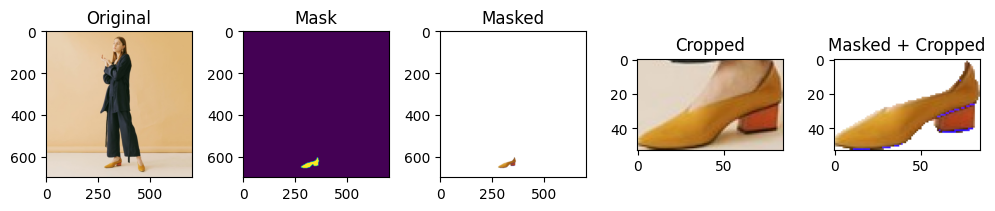

32:sleeve
 [109.12752 275.45706 242.54976 409.17844] 0.994166


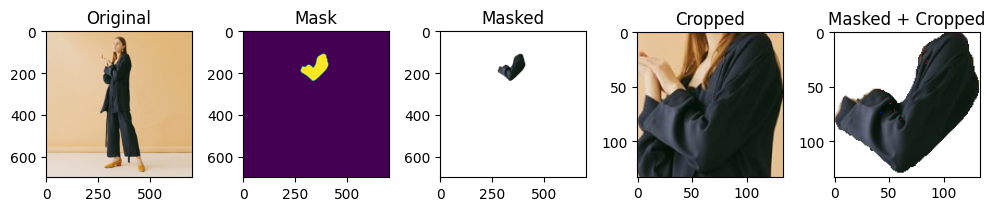

24:shoe
 [613.34735 433.9486  673.33124 474.50812] 0.98419535


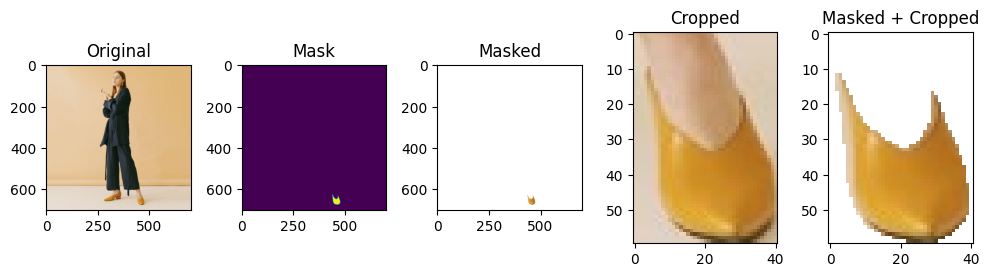

32:sleeve
 [180.67557 272.6944  253.99626 310.34943] 0.9480967


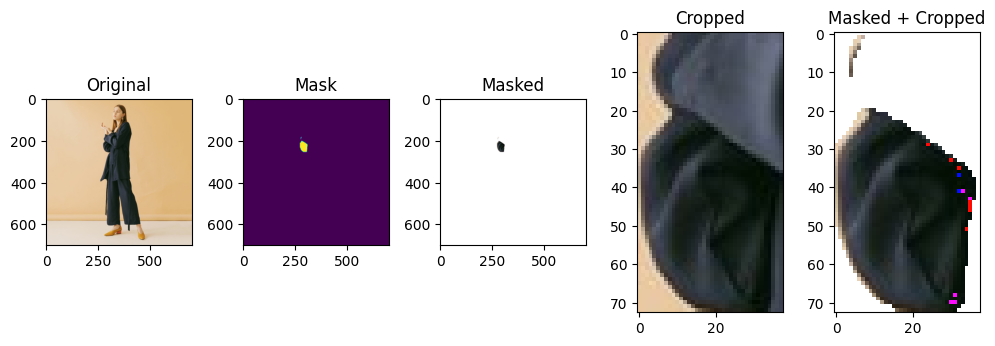

4:cardigan
 [103.18594 268.50827 404.97888 415.36755] 0.90550655


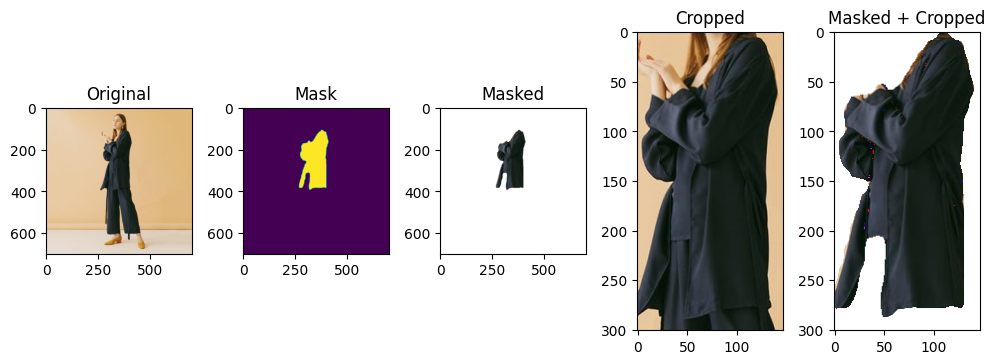

7:pants
 [298.4001  282.70984 624.44977 412.80878] 0.6959629


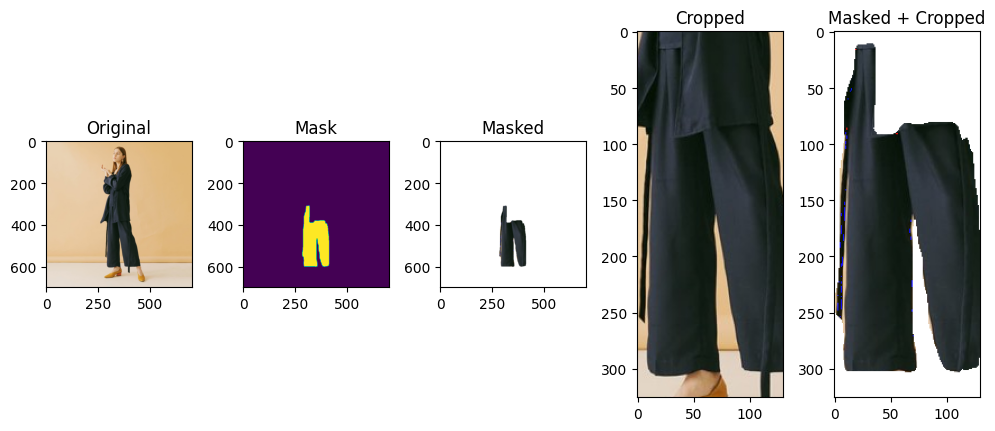

34:neckline
 [144.56404 314.5378  160.44771 328.8961 ] 0.48726913


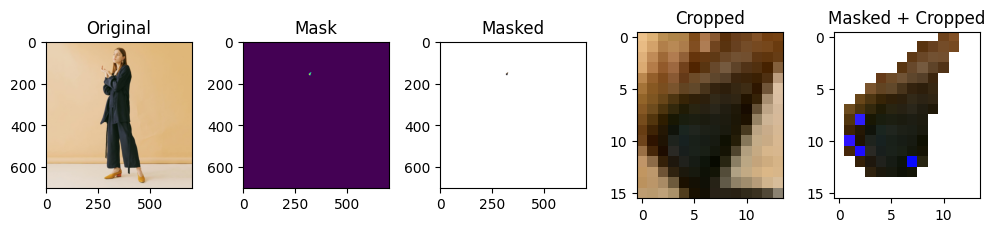

11:dress
 [111.30223 267.71573 617.54144 452.68246] 0.45167127


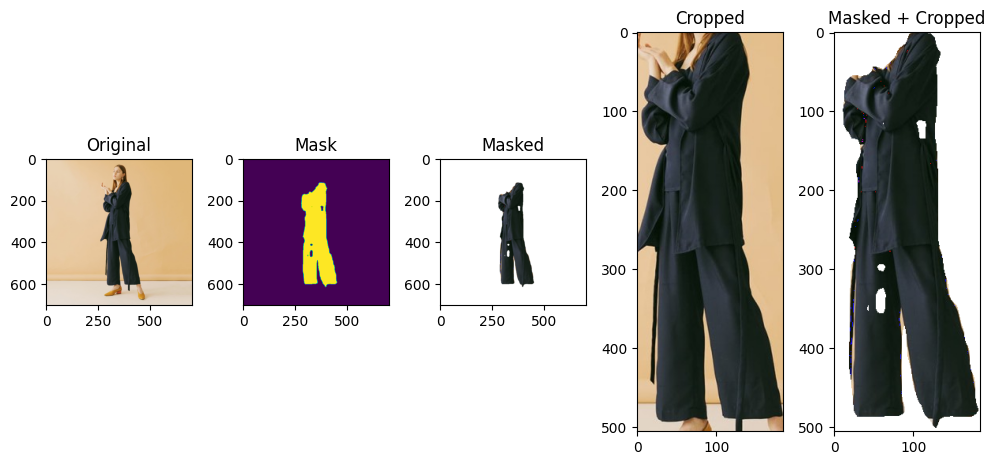

12:jumpsuit
 [111.99953 280.7798  619.4966  449.61887] 0.41427314


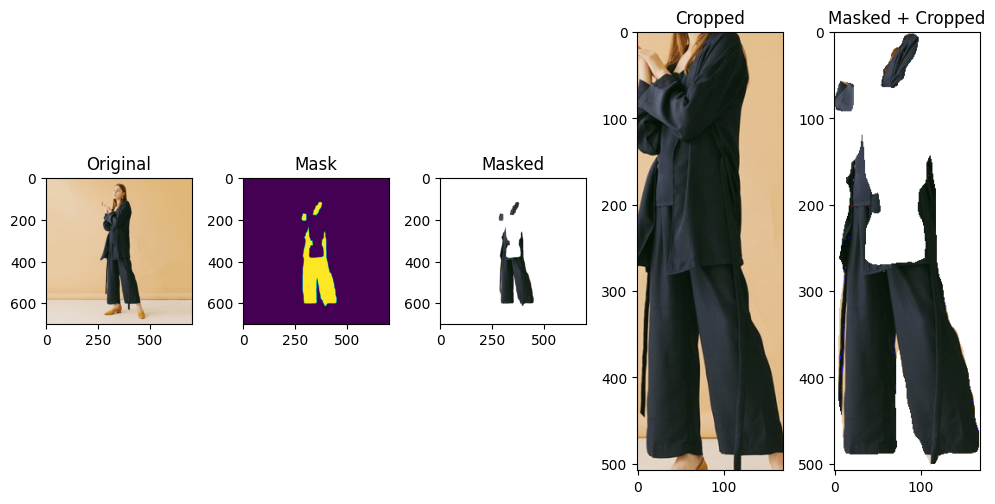

34:neckline
 [107.4677  308.66327 182.22383 378.3486 ] 0.376935


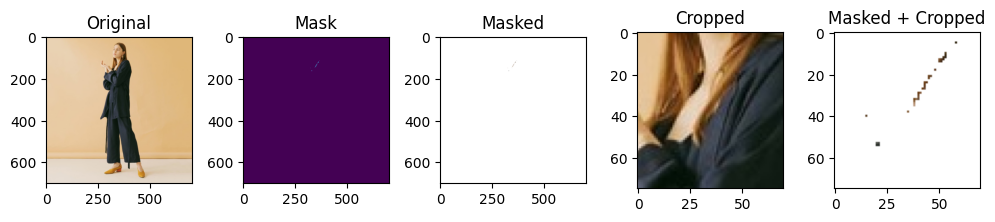

34:neckline
 [145.33229 317.21674 164.20319 336.92047] 0.3669544


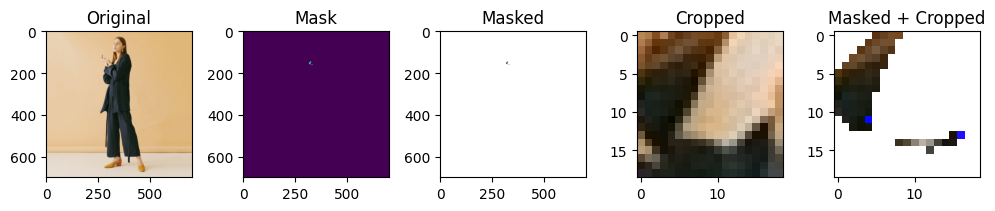

10:coat
 [123.83711 265.4922  401.82336 412.97754] 0.23561142


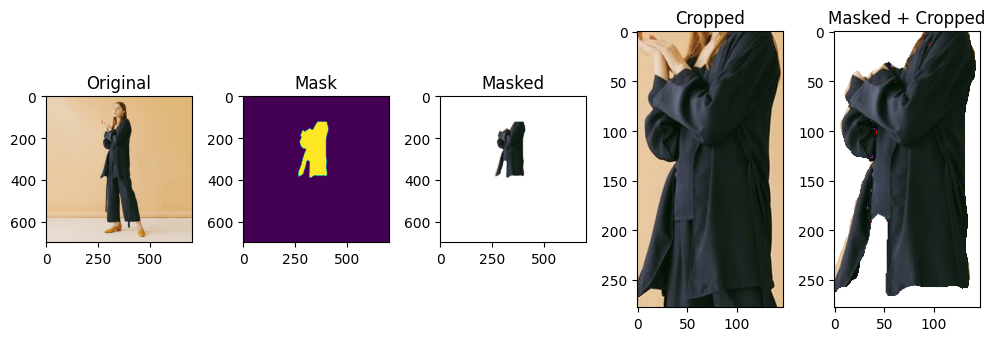

9:skirt
 [300.61414 285.53168 622.2174  450.76437] 0.18985455


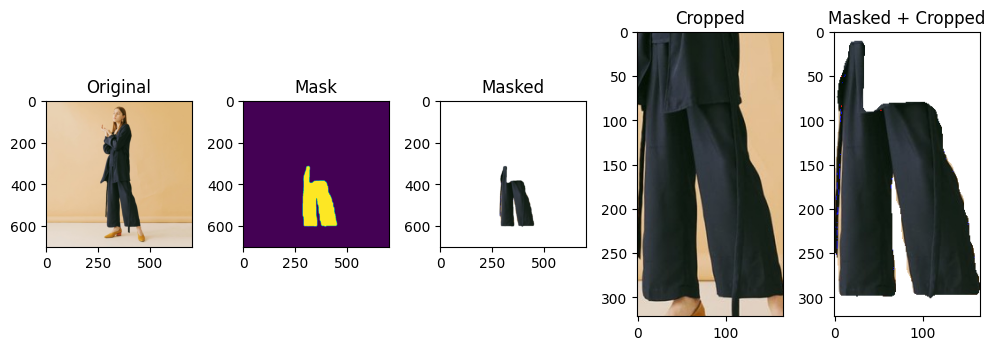

29:collar
 [144.60384 314.26685 161.13089 329.2365 ] 0.18904632


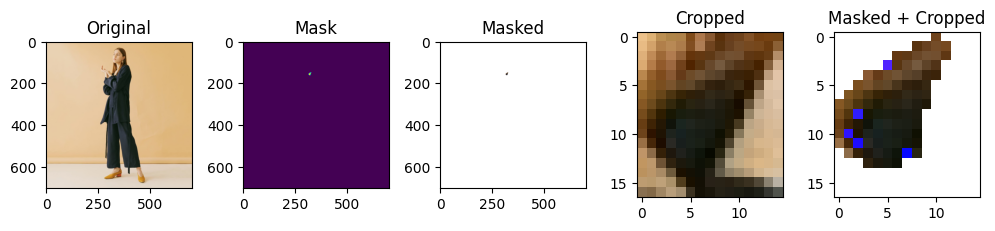

34:neckline
 [156.25822 325.51944 166.02977 337.82278] 0.14793633


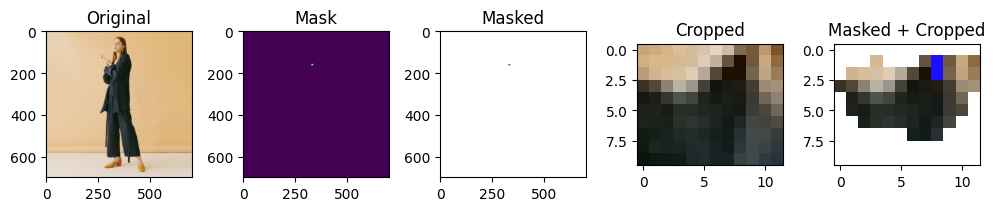

2:top, t-shirt, sweatshirt
 [119.45444 270.3371  398.37766 419.60138] 0.13094182


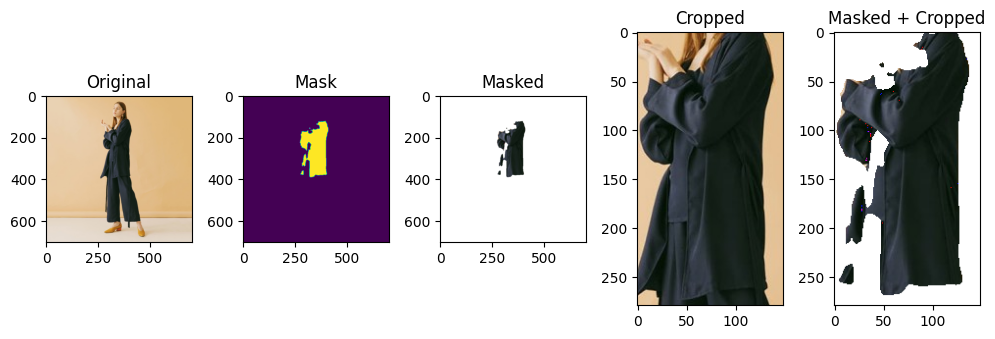

34:neckline
 [146.55054 319.49692 152.16124 326.82318] 0.10749536


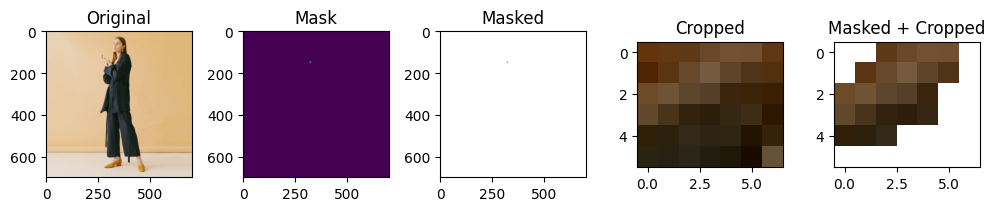

1:shirt, blouse
 [139.57152 260.01428 400.30264 413.0338 ] 0.10384129


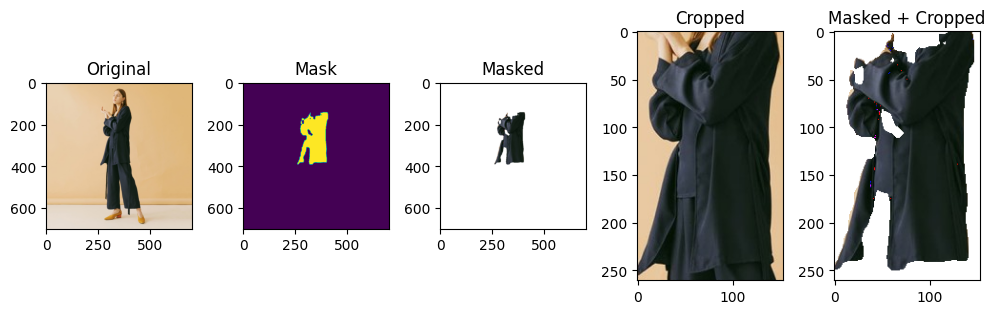

2:top, t-shirt, sweatshirt
 [139.92537 291.49475 348.1316  363.76825] 0.09845479


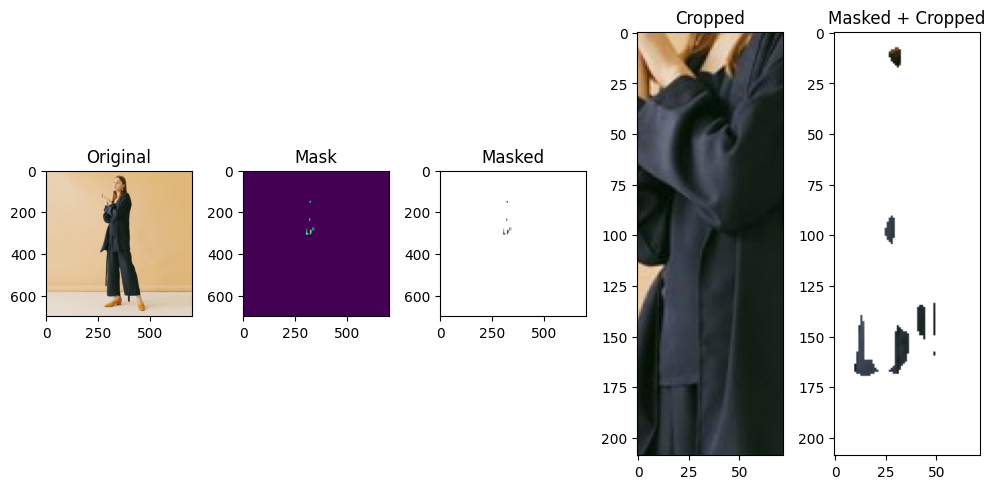

34:neckline
 [146.24391 316.08203 153.97789 325.8477 ] 0.08003639


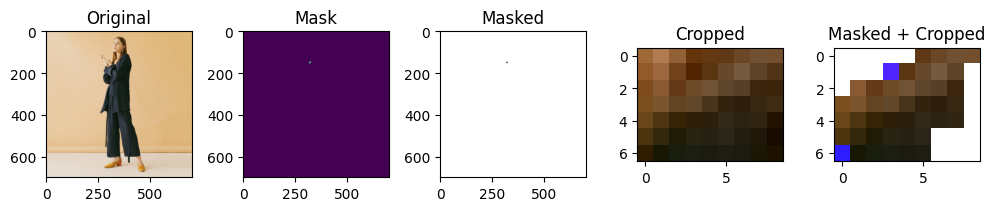

10:coat
 [111.54199 262.26782 610.73083 450.05176] 0.079636306


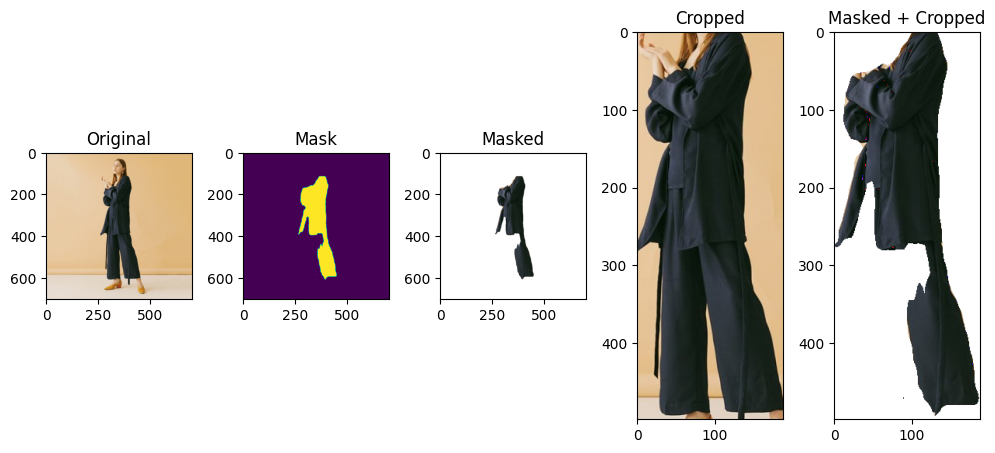

5:jacket
 [109.19552 258.32947 387.86377 414.78778] 0.069505185


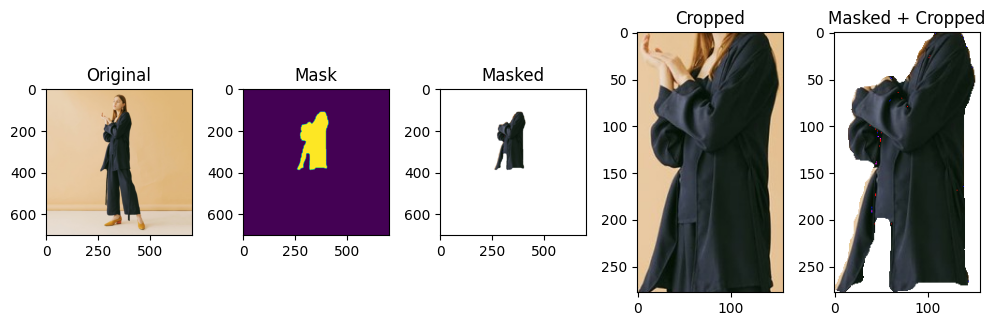

34:neckline
 [128.72705 312.81696 170.55324 345.4445 ] 0.06548988


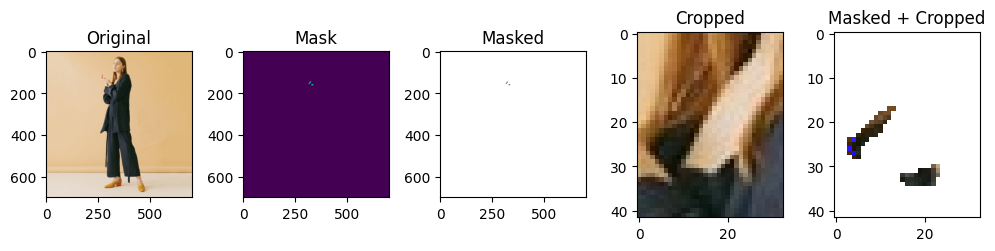

30:lapel
 [212.64674 300.20444 314.46725 329.3534 ] 0.056704864


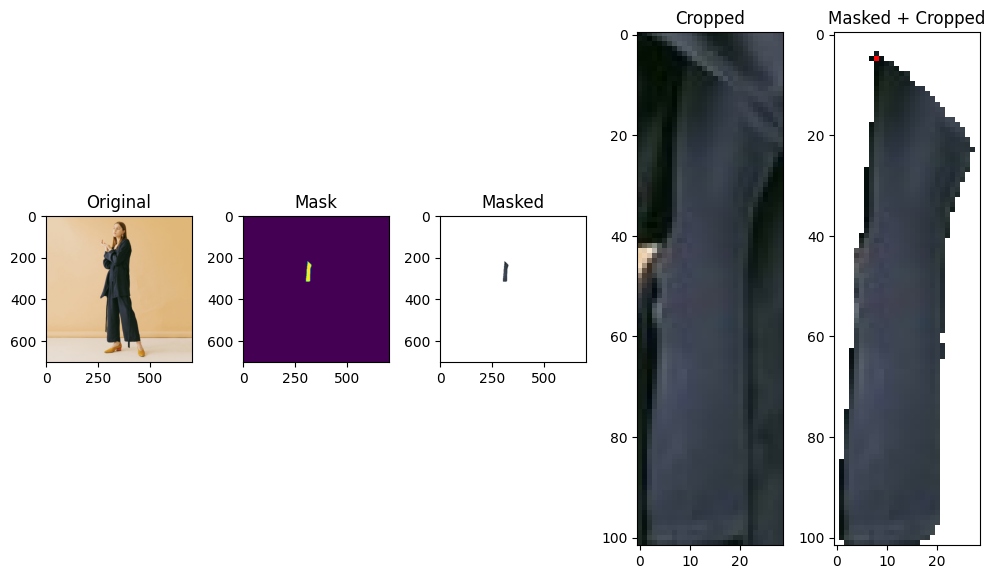

32:sleeve
 [166.6674  275.7923  200.78375 297.45227] 0.050025392


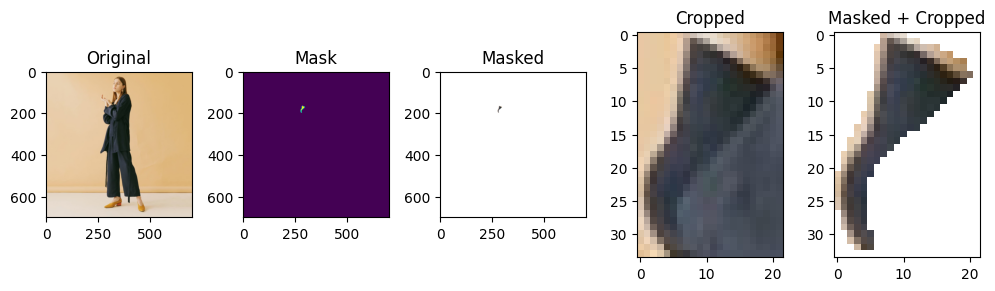

In [49]:
import os
os.getcwd()
os.chdir('processing/detection')

import pycocotools.mask as mask_util
import numpy as np
import matplotlib.pyplot as plt
import cv2

detect_file = np.load("/Users/kenjilaurens/Desktop/quo/details/atsthelabel/ATSHELABEL LOUNGE SET ESSENTIAL NAVY/processed/23222026_ac46c731-342c-4a4c-be9f-19dc0d0d7bbc_1080_1080.jpg.npy", allow_pickle=True)
with open('datasets/fashionpedia_label_map.csv', 'r') as f:
    mapping = f.readlines()
output = [detect_file]
for item_idx in range(len(output)):
    # item_idx=25
    for i in range(len(output[item_idx].item()['masks'])):    
        # if output[item_idx]['classes'][i] in (1,2,3):
            # 1:shirt, blouse
            # 2:top, t-shirt, sweatshirt
            # 3:sweater
    
            print(mapping[output[item_idx].item()['classes'][i] - 1], output[item_idx].item()['boxes'][i],  output[item_idx].item()['scores'][i])
            fig, ax = plt.subplots(1, 5, figsize=(10,10))
            # img = cv2.imread(output[item_idx].item()['image_file'])
            img = cv2.imread("../../" + output[item_idx].item()['image_file'].replace('\\','/'))
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[0].imshow(image)
            ax[0].set_title('Original')
    
             # Encoded mask string
            encoded_mask_string = output[item_idx].item()['masks'][i]
            
            # Decode the mask
            decoded_mask = mask_util.decode(encoded_mask_string)
            
            # Visualize the mask        
            ax[1].imshow(decoded_mask)        
            ax[1].set_title('Mask')
    
            masked_img = np.einsum('hwc,hw->hwc', image, decoded_mask)
            masked_img[masked_img == 0] = 255
            ax[2].imshow(masked_img)
            ax[2].set_title('Masked')
    
            #Crop to bounding boxes        
            y1, x1, y2, x2 = np.ceil(output[item_idx].item()['boxes'][i]).astype(int)
            crop_img = image[y1:y2, x1:x2]
            ax[3].imshow(crop_img)
            ax[3].set_title('Cropped')
    
            crop_masked_img = masked_img[y1:y2, x1:x2]
            crop_masked_img[crop_masked_img == 0] = 255
            ax[4].imshow(crop_masked_img)
            ax[4].set_title('Masked + Cropped')
           
            plt.tight_layout()
            plt.show()


In [2]:
import os
from google.cloud import storage
from google.cloud import vision

storage_client = storage.Client(project="argon-producer-437209-a7")
buckets = storage_client.list_buckets()
print("Buckets:")
for bucket in buckets:
    print(bucket.name)
print("Listed all storage buckets.")

Buckets:
quo-trial
Listed all storage buckets.


In [27]:
blobs = storage_client.list_blobs('quo-trial')

In [28]:
files = [x for x in blobs if '\\' in x.name]

In [29]:
len(files)

12948

In [30]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=10) as workers:
    workers.map(lambda x: (x.delete(), print(f"Deleted: {x.name}")), files)

Deleted: details\atsthelabel\ATSTHELABEL PARSLEY DRESS\images\a10537c5-13cc-433e-b392-8c928b2d2ddb.jpg
Deleted: details\atsthelabel\ATSTHELABEL PARTICIPATE BONE PANTS\details_2024-10-31.jsonDeleted: details\atsthelabel\ATSTHELABEL PARSLEY DRESS\images\processed\a10537c5-13cc-433e-b392-8c928b2d2ddb.jpg.npy
Deleted: details\atsthelabel\ATSTHELABEL PARSLEY DRESS\images\processed\eade37ac-c335-4f42-98dc-6609751d8a33.jpg.npy

Deleted: details\atsthelabel\ATSTHELABEL PARSLEY DRESS\images\e3e87bd3-d95d-4486-8836-7d3127871e17.jpg
Deleted: details\atsthelabel\ATSTHELABEL PARSLEY DRESS\product_info.json
Deleted: details\atsthelabel\ATSTHELABEL PARTICIPATE BONE PANTS\images\23222026_b6502e91-3224-4f21-b229-e237491a5ec5_1282_1282.jpg
Deleted: details\atsthelabel\ATSTHELABEL PARTICIPATE BONE PANTS\images\processed\23222026_277524ae-8c65-4719-9c37-474e5e773806_1282_1282.jpg.npy
Deleted: details\atsthelabel\ATSTHELABEL PARTICIPATE BONE PANTS\images\processed\23222026_742ceeab-3670-4adb-bc15-7a113e625

In [17]:
ok_files = storage_client.list_blobs('quo-trial', prefix='details', max_results=10)
ok_files = [x for x in ok_files]

In [24]:
ok_files[0].name

'details/atsthelabel/ATSHELABEL LOUNGE SET ESSENTIAL NAVY/details_2024-10-31.json'